In [2]:
import sys
sys.path.append('reflutils')
import reflutils as ru
import numpy as np

%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
import pandas as pd
sns.set_style("darkgrid")
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

# Transfer Matrix Method

Removing the low Q, and brewter angle stuff. 

By inspection there are 4 points in the low angle double reflection regiem, and data less that $10^{-6}$ is non physical as there is a brewster angle present there.  

## Bare Silicon

To start off with, we need a way to determine the thickness of silocon oxide present before deposition of the ZnPc. Thus we start by loading in the bare silicon data and fitting it to a model of just silicon and silicon oxide.

<Axes: xlabel='Q'>

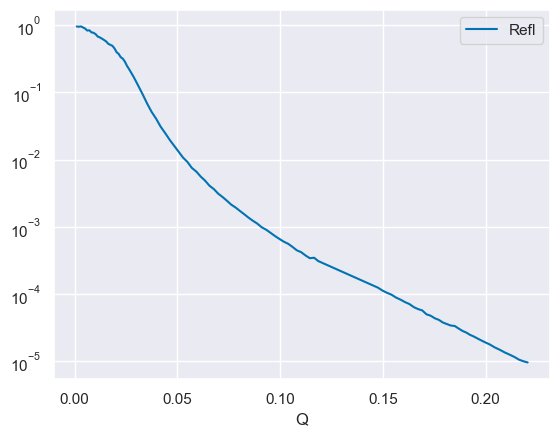

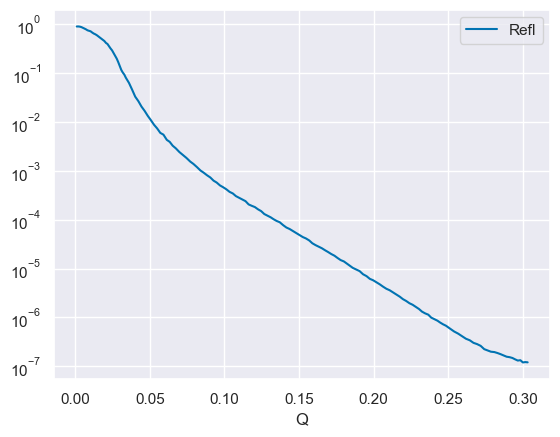

In [3]:
d_path = r"C:\Users\Harlan Heilman\Washington State University (email.wsu.edu)\Carbon Lab Research Group - Documents\Harlan Heilman\.refl\data"

bareSi_250_masked = pd.read_csv(d_path+r"\bareSi_250_masked.csv", index_col=0)
bareSi_320 = pd.read_csv(d_path+r"\bareSi_320.csv", index_col=0)

bareSi_250_masked.plot(x = "Q", y = "Refl", logy=True)
bareSi_320.plot(x = "Q", y = "Refl", logy=True)

### Converting to the right format

To start off, we need a function to transform the refl data frames into a form that can be used by the fitting function. This is done by the following function:

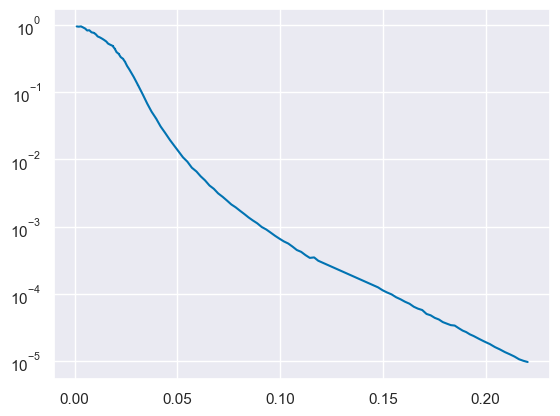

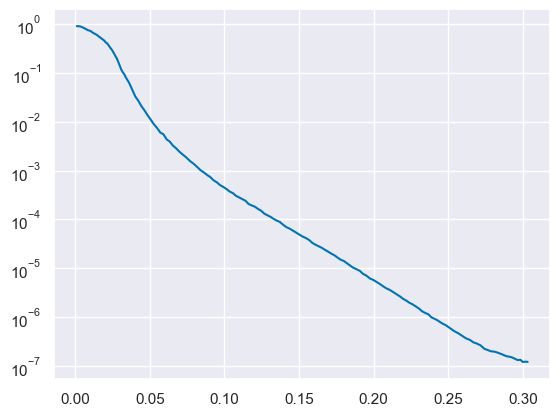

In [4]:
def to_refnx_dataset(refl):
    data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)

bareSi_250_masked_dataset = to_refnx_dataset(bareSi_250_masked)
bareSi_320_dataset = to_refnx_dataset(bareSi_320)

bareSi_250_masked_dataset.plot()
plt.yscale("log")
bareSi_320_dataset.plot()
plt.yscale("log")

Now we need to construct the slab mosel using a series of slabs. This is done using the `PXR_MaterialSLD` and the `PXR_SLD`.

- `PXR_MaterialSLD` uses the periodic table package to determine the scattering length density of the material.
- `PXR_SLD` is a class that allows for user constructed materials

### Fitting the data

Here we are looking at the bare sillicon substrait collected at two energies. The first is at 250 eV, an energy well below the carbon k-edge. This provides us with the means to determine the thickness of the silicon oxide layer. In the second, we are looking at 320 eV, an energy in the middle of the carbon k-edge allowing us to probe adventitious carbon on the surface of the sample.

This means that we will be using the first to determine the total thickness of the sample and the second to determine the thickness of any possible carbon layers. Thus the model for such a sample looks something like this 

 |-Vaccume-|-Adventitious Carbon-|-Silicon Oxide-|-Silicon-|

The model function can then be constructed using known sld's for 250 eV and 320 eV.

We will start by allowing the density of Carbon to vary from the standard density. This will give us extra parameters to work with, without requiring the index of refraction to varry. This will be our first order approximation, and we will then transition into a higher order approximation by allowing the index of refraction of this carbon layer to varry. 

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

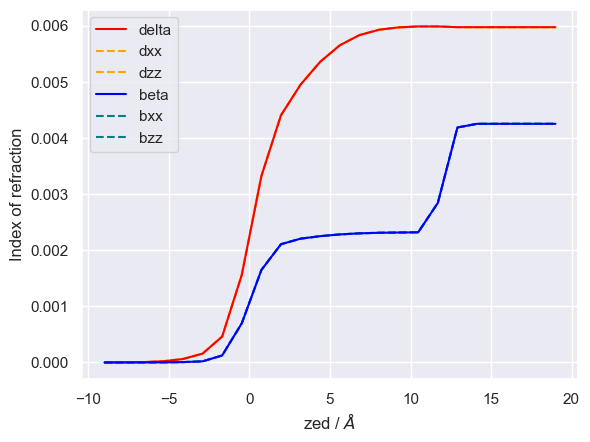

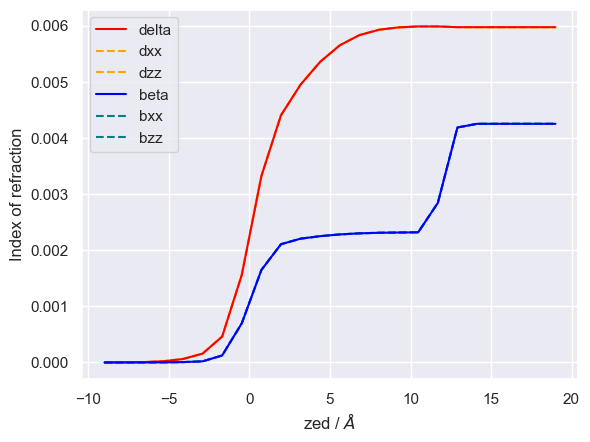

In [114]:
en1 = 250 # eV
en2 = 320 # eV


si = PXR_MaterialSLD("Si", 2.33, name="Si") # substrate
vacuum = PXR_MaterialSLD("", 1, name="Vacuum") # Superstrate
sio21 = PXR_MaterialSLD("SiO2", 2.28, name="SiO21") # surface oxide
n_gunk_1 = 0.003 + 0.002j
carbon1 = PXR_SLD(n_gunk_1, symmetry="iso", name="Carbon1") # surface carbon

sio22 = PXR_MaterialSLD("SiO2", 2.28, name="SiO22") # surface oxide
n_gunk_2 = 0.003 + 0.002j
carbon2 = PXR_SLD(n_gunk_2, symmetry="iso", name="Carbon2") # surface carbon


si_slab = si(0, 0.5)

sio2_slab_en1 = sio21(10, 3)
carbon_slab_en1 = carbon1(2,1)
sio2_slab_en2 = sio22(10, 3)
carbon_slab_en2 = carbon2(2,1)

structure1 = vacuum | carbon_slab_en1 | sio2_slab_en1 | si_slab
structure2 = vacuum | carbon_slab_en2 | sio2_slab_en2 | si_slab

structure1.plot()
structure2.plot()

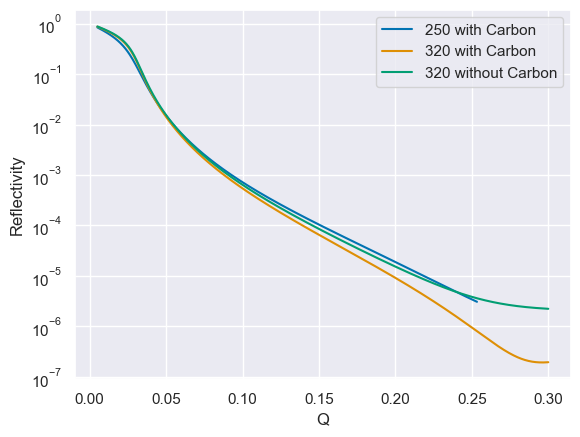

In [163]:
model_1 = PXR_ReflectModel(structure1, energy=en1, pol = "s", name="model1")
model_2 = PXR_ReflectModel(structure2, energy=en2, pol = "s", name="model2")
model_3 = PXR_ReflectModel(structure1, energy=en2, pol = "s", name="model3")
obj_1 = Objective(model_1, bareSi_250_masked_dataset, transform=Transform("logY"))
obj_2 = Objective(model_2, bareSi_320_dataset, transform=Transform("logY"))
obj_3 = Objective(model_3, bareSi_320_dataset, transform=Transform("logY"))

q = np.linspace(0.005, 0.3, 1000)
plt.plot(q, model_1(q), label="250 with Carbon")
plt.plot(q, model_2(q), label="320 with Carbon")
plt.plot(q, model_3(q), label="320 without Carbon")
plt.yscale("log")
plt.ylabel("Reflectivity")
plt.xlabel("Q")
plt.legend()

With these structures in place, we now construct the objective function. This will link the data to the model and allow for the fitting of the data.

As you can see, the current model is constructed using a compleate guess on thickness and roughness of the various parameters and poorly fits the data. So in the next step, we need to fit the 250 eV dataset and determine the goodness of that fit. 

#### Choosing the right parameters to vary
Now we want to know the exact values for each parameter in the system, but there are some that we allready know, or allready have a very good understanding of. Namely, we know the density of silicon to a very high degree of accuracy, and we know the density of silicon oxide to a very high degree of accuracy. Thus we can fix these parameters to their known values and only fit the thickness of the silicon oxide layer. 

If this does not work out, we can add the silicon dioxide density to our list of varying parameters and fit that as well.

In [166]:
objective = GlobalObjective([obj_1, obj_2])

si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds = (0,2))

# Energy 1
sio2_slab_en1.thick.setp(vary=True, bounds = (5,15))
sio2_slab_en1.rough.setp(vary=True, bounds = (1,5))

carbon_slab_en1.thick.setp(vary=True, bounds = (0,10))
carbon_slab_en1.rough.setp(vary=True, bounds = (0,2)) 
carbon_slab_en1.sld.beta.setp(vary=True, bounds = (0,0.01))
carbon_slab_en1.sld.delta.setp(vary=True, bounds = (0,0.01))

# Energy 2
sio2_slab_en2.thick.setp(vary=True, bounds = (10, 15))
sio2_slab_en2.rough.setp(vary=True, bounds = (1,5))

carbon_slab_en2.thick.setp(vary=True, bounds = (2,8))
carbon_slab_en2.rough.setp(vary=True, bounds = (0,carbon_slab_en2.thick.value))
carbon_slab_en2.sld.beta.setp(vary=True, bounds = (0,0.01))
carbon_slab_en2.sld.delta.setp(vary=True, bounds = (0,0.01))

print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon1_thick', value=2 +/- 1.24e-08, bounds=[0.0, 10.0]>
<Parameter:'Carbon1_diso' , value=0.00618843 +/- 7.47e-07, bounds=[0.0, 0.01]>
<Parameter:'Carbon1_biso' , value=0.00404523 +/- 3.02e-07, bounds=[0.0, 0.01]>
<Parameter:'Carbon1_rough', value=0.958109 +/- 9.77e-07, bounds=[0.0, 2.0]>
<Parameter: 'SiO21_thick' , value=13.904 +/- 5.25e-06, bounds=[5.0, 15.0]>
<Parameter: 'SiO21_rough' , value=3.18722 +/- 9.55e-06, bounds=[1.0, 5.0]>
<Parameter:'Carbon2_thick', value=4.76186 +/- 0.892, bounds=[2.0, 8.0]>
<Parameter:'Carbon2_diso' , value=0.00498539 +/- 0.00137, bounds=[0.0, 0.01]>
<Parameter:'Carbon2_biso' , value=0.00306686 +/- 0.00233, bounds=[0.0, 0.01]>
<Parameter:'Carbon2_rough', value=2.63332 +/- 0.0139, bounds=[0.0, 4.761861239134398]>
<Parameter: 'SiO22_thick' , value=10.0001 +/- 0.863, bounds=[10.0, 15.0]>
<Parameter: 'SiO22_rough' , value=1.00009 +/- 0.

In [167]:
fitter1 = CurveFitter(obj_1)
fitter2 = CurveFitter(obj_2)

100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


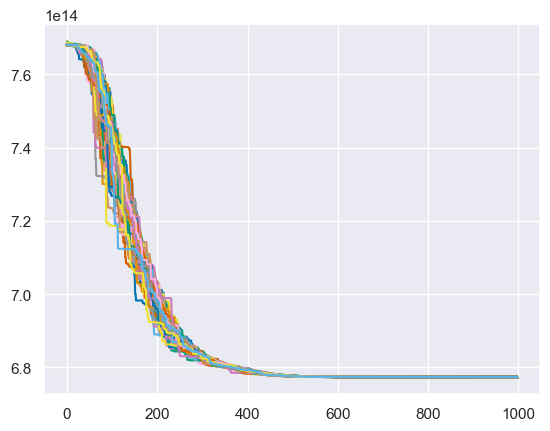

In [168]:
fitter1.initialise(pos="jitter", random_state=1)
chain = fitter1.sample(1000)

lp = fitter1.logpost
plt.plot(-lp)

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon1_thick', value=0.205992 +/- 0.377, bounds=[0.0, 10.0]>
<Parameter:'Carbon1_diso' , value=0.00459883 +/- 0.00168, bounds=[0.0, 0.01]>
<Parameter:'Carbon1_biso' , value=0.00405085 +/- 0.00161, bounds=[0.0, 0.01]>
<Parameter:'Carbon1_rough', value=1.95925 +/- 0.379, bounds=[0.0, 2.0]>
<Parameter: 'SiO21_thick' , value=14.999 +/- 0.0984, bounds=[5.0, 15.0]>
<Parameter: 'SiO21_rough' , value=3.65297 +/- 0.118, bounds=[1.0, 5.0]>


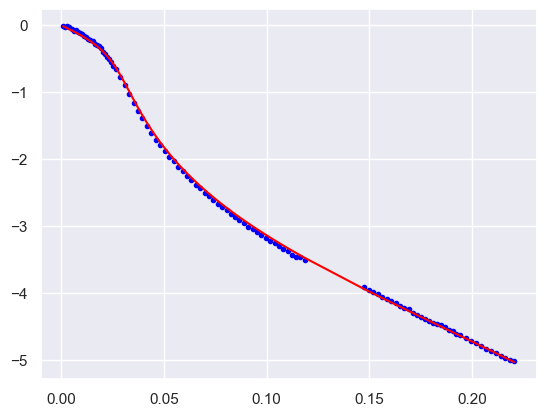

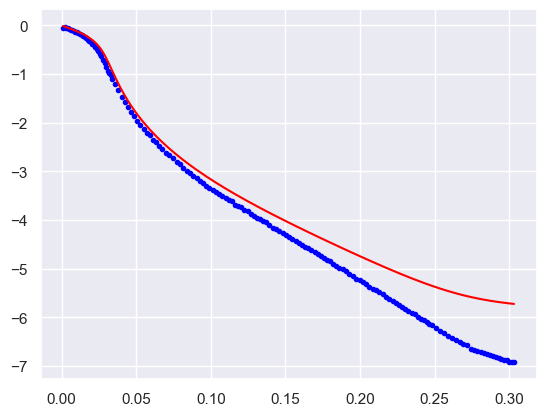

In [169]:
obj_1.plot()
obj_3.plot()
print(obj_1.varying_parameters())

We neeed to have a better 

100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


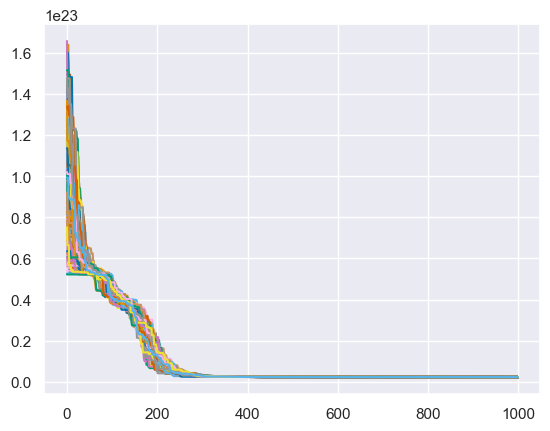

In [158]:
fitter2.initialise(pos = "jitter", random_state=1)
chain = fitter2.sample(1000)

lp = fitter2.logpost
plt.plot(-lp)

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon2_thick', value=2.63334 +/- 2.37e-06, bounds=[2.0, 8.0]>
<Parameter:'Carbon2_diso' , value=0.0046729 +/- 2.87e-06, bounds=[0.0, 0.01]>
<Parameter:'Carbon2_biso' , value=0.00217937 +/- 1.94e-06, bounds=[0.0, 0.01]>
<Parameter:'Carbon2_rough', value=4 +/- 8.29e-07, bounds=[0.0, 4.0]>
<Parameter: 'SiO22_thick' , value=13.8361 +/- 1.77e-06, bounds=[10.0, 15.0]>
<Parameter: 'SiO22_rough' , value=1 +/- 2.65e-06, bounds=[1.0, 5.0]>


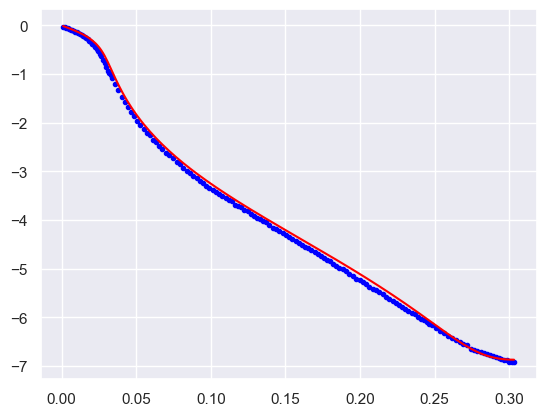

In [145]:
obj_2.plot()
print(obj_2.varying_parameters())

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

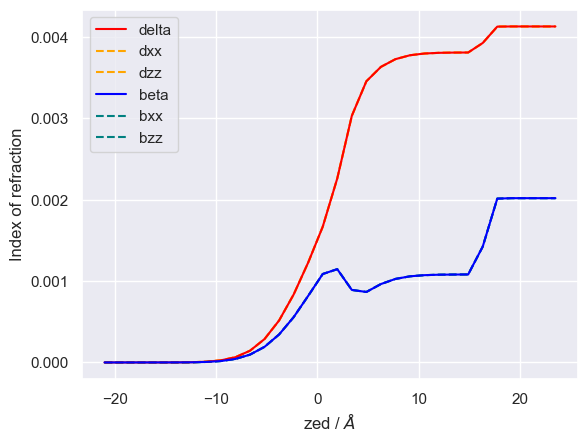

In [148]:
structure2.plot()

Old Results That I am updating

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=5.4805 +/- 0.531, bounds=[2.0, 6.0]>
<Parameter:'Carbon_rough' , value=1.4401 +/- 0.629, bounds=[0.0, 2.0]>
<Parameter: 'SiO2_thick'  , value=14.1797 +/- 0.233, bounds=[9.0, 15.0]>
<Parameter: 'SiO2_rough'  , value=2.19286 +/- 0.713, bounds=[1.0, 5.0]>


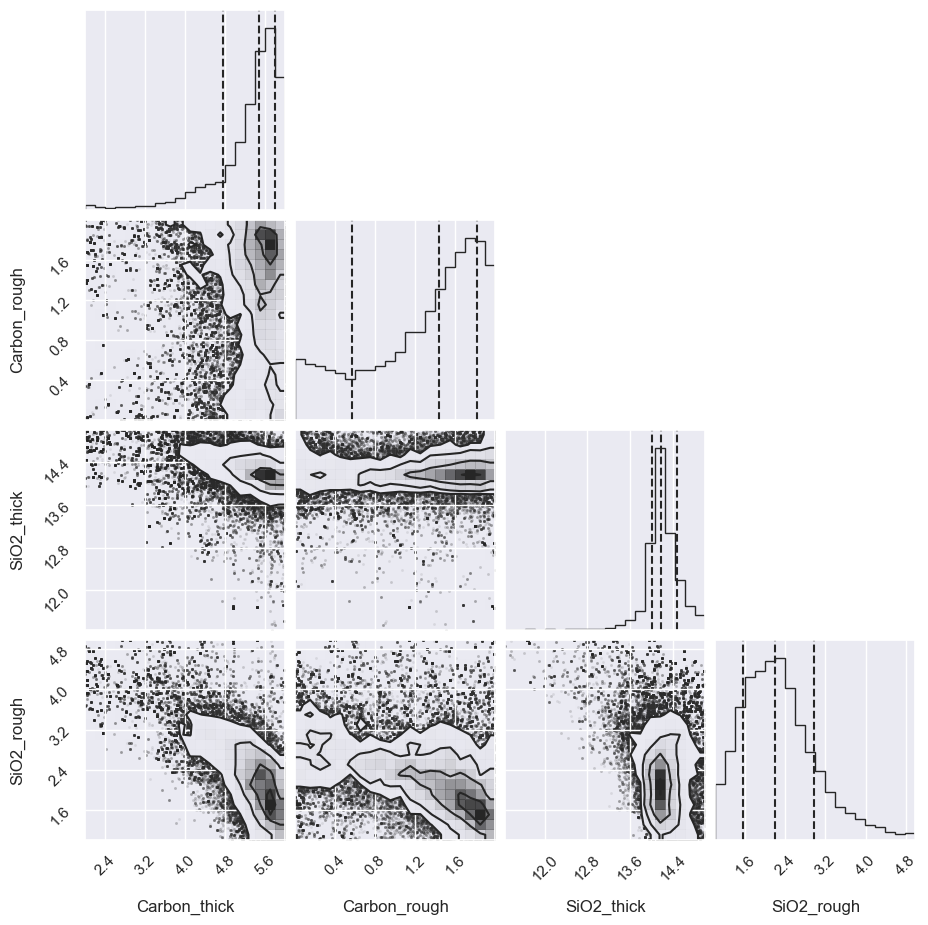

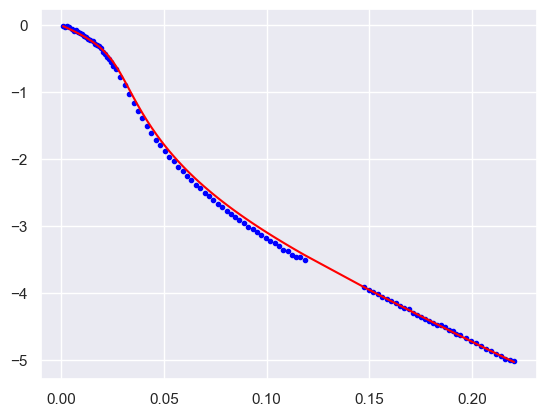

In [162]:
objective1.corner()
objective1.plot()
print(objective1.varying_parameters())

(<Figure size 640x480 with 1 Axes>, <Axes: >)

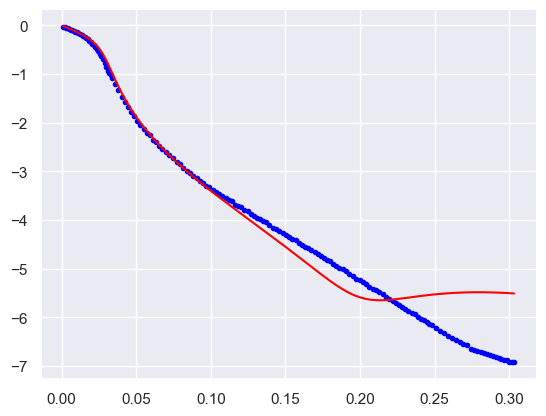

In [163]:
objective2.plot()

In [174]:
fitter2.initialise("jitter")
chain = fitter2.sample(10000)
fitter2.reset()
chain = fitter2.sample(5000)

  1%|          | 63/10000 [00:40<1:45:33,  1.57it/s]


KeyboardInterrupt: 

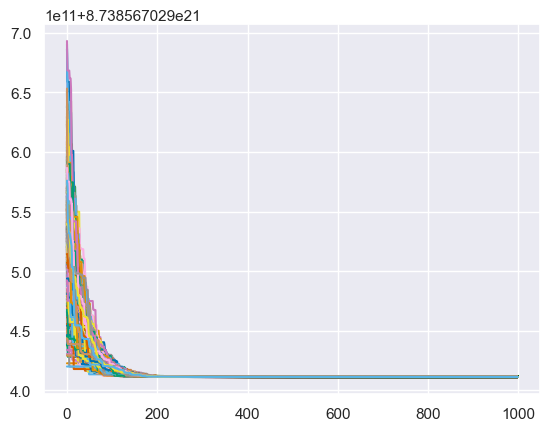

In [170]:
lp = fitter2.logpost
fig = plt.plot(-lp)

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon_thick' , value=4 +/- 7.55e-15, bounds=[4.0, 6.0]>
<Parameter:'Carbon_rough' , value=2.67901 +/- 6.09e-09, bounds=[0.8, 3.0]>
<Parameter: 'SiO2_thick'  , value=12 +/- 2.66e-14, bounds=[12.0, 15.0]>
<Parameter: 'SiO2_rough'  , value=1 +/- 1.69e-13, bounds=[1.0, 4.0]>


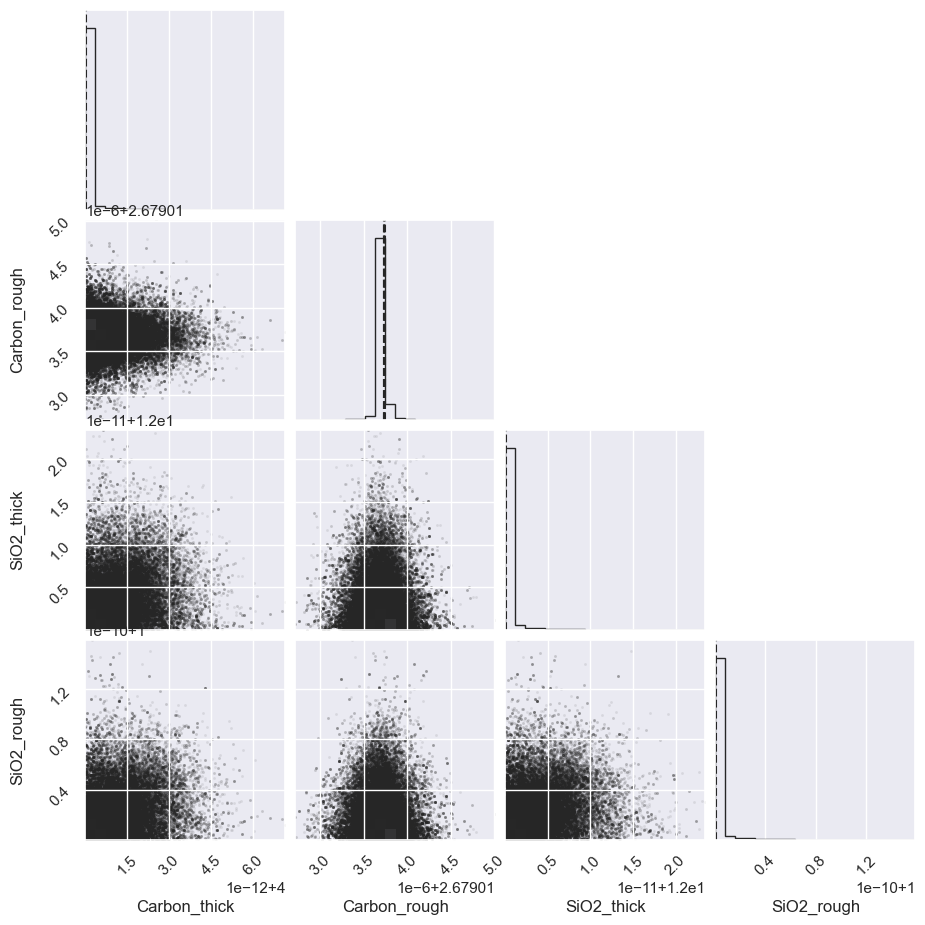

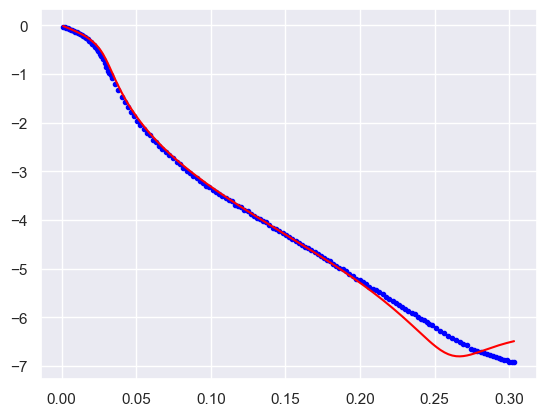

In [171]:
objective2.corner()
objective2.plot()
lp = fitter2.logpost
print(objective2.varying_parameters())

(<Figure size 640x480 with 1 Axes>, <Axes: >)

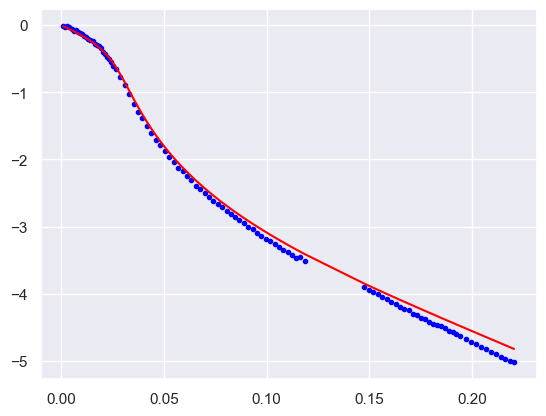

In [172]:
objective1.plot()